<a href="https://colab.research.google.com/github/alifele/EEG-computation/blob/master/RandomForests_with_important_Feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Important libraries

In [4]:
!pip install mat4py
import numpy as np
import matplotlib.pyplot as plt
import mat4py as mt
import os
from IPython.display import Image
from IPython.core.display import HTML 
from itertools import combinations
from numpy.fft import fft
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.metrics import confusion_matrix, classification_report

# Importing Data from GitHub Page

In [5]:
!git clone https://github.com/alifele/EEG-computation.git
%cd EEG-computation

fatal: destination path 'EEG-computation' already exists and is not an empty directory.
/content/EEG-computation/EEG-computation


In [0]:
disorder_dic = []
directory = os.fsencode('EEG Data/disorder')
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    disorder_dic.append(np.array(mt.loadmat('EEG Data/disorder/{}'.format(filename))[filename.split('.')[0]]))
    
channels_disorder = [ [] for i in range(len(disorder_dic))]  #channels[person][channel] it will be a numpy array
j=0;
for person in channels_disorder:
    for i in range(19):
        person.append(disorder_dic[j][:,i])
    j+=1
        
normal_dic = []
directory = os.fsencode('EEG Data/normal')
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    normal_dic.append(np.array(mt.loadmat('EEG Data/normal/{}'.format(filename))[filename.split('.')[0]]))
    
channels_normal = [ [] for i in range(len(normal_dic))]  #channels[person][channel] it will be a numpy array
j=0;
for person in channels_normal:
    for i in range(19):
        person.append(normal_dic[j][:,i])
    j+=1    
        
data = {"N":channels_normal,
      "D":channels_disorder}



(-4, 256.0)

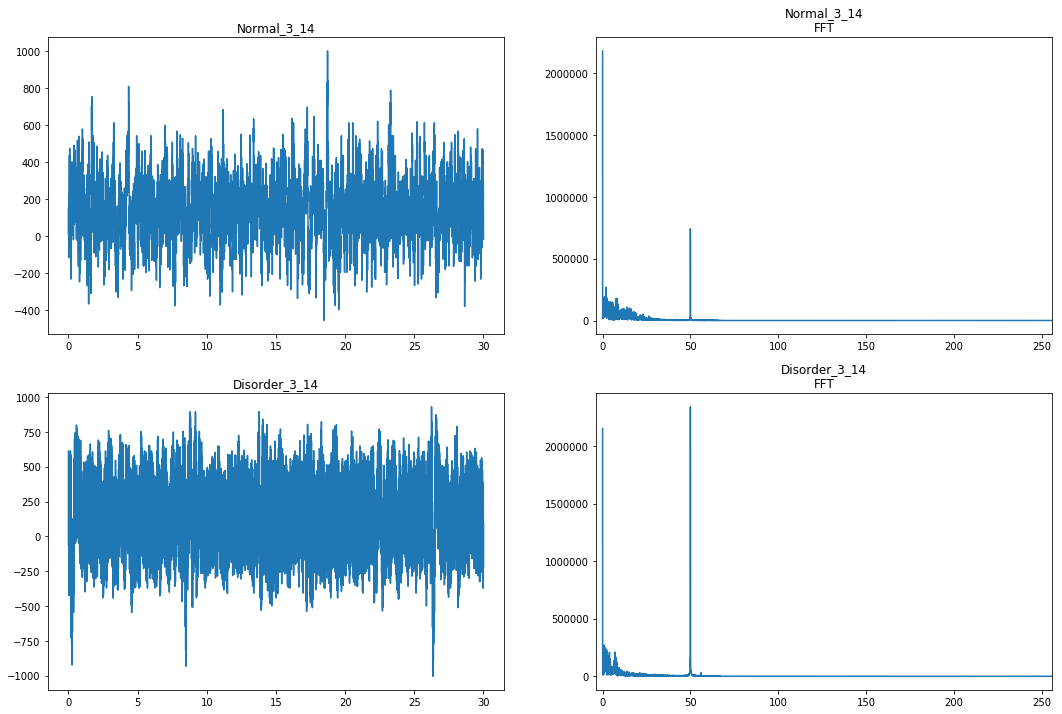

In [7]:
t = np.linspace(0,30,512*30)
f = np.linspace(0,512,512*30)
fig = plt.figure( 'Example Plot', figsize=(18,12))
ax = fig.add_subplot(2,2,1, title = 'Normal_3_14')
ax.plot(t,data["N"][18][16])
ax = fig.add_subplot(2,2,2, title = 'Normal_3_14\nFFT')
ax.plot(f,abs(np.fft.fft(data["N"][18][16])))
ax.set_xlim([-4,512/2])
ax = fig.add_subplot(2,2,3, title = 'Disorder_3_14')
ax.plot(t,data["N"][54][16])
ax = fig.add_subplot(2,2,4, title = 'Disorder_3_14\nFFT')
ax.plot(f,abs(np.fft.fft(data['N'][54][16])))
ax.set_xlim([-4,512/2])


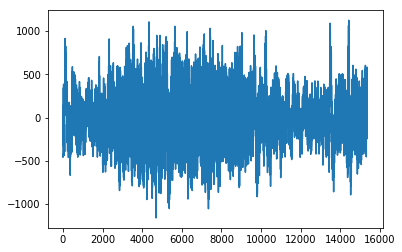

In [8]:
#plt.plot(abs(np.fft.fft(data["N"][18][16]))-abs(np.fft.fft(data["N"][5][16])))
plt.plot(data['N'][8][16] - data['N'][54][16])

## Generating New Data

In [0]:
def New_Data_Generator_N():
    number_of_samples =  50
    randlist = (132 * np.random.random(number_of_samples)).astype(int)
    new_patients = list(data['N'][i] for i in randlist)
    
    index = [ i for i in range(number_of_samples)]
    comb = list( combinations(index, 2))
    new_data = [[] for i in range(len(comb))]
    person = 0
    for x,y in comb:
        for chan in range(19):
            new_data[person].append((new_patients[x][chan] + new_patients[y][chan] )/2)
        data['N'].append(new_data[person])
        person += 1

    
def New_Data_Generator_D():
    number_of_samples = 50
    randlist = (132 * np.random.random(number_of_samples)).astype(int)
    new_patients = list(data['D'][i] for i in randlist)
    
    index = [ i for i in range(number_of_samples)]
    comb = list( combinations(index, 2))
    new_data = [[] for i in range(len(comb))]
    person = 0
    for x,y in comb:
        for chan in range(19):
            new_data[person].append((new_patients[x][chan] + new_patients[y][chan] )/2)
        data['D'].append(new_data[person])
        person += 1

In [0]:
New_Data_Generator_N()
New_Data_Generator_D()

In [11]:
n_D , n_N = len(data['D']), len(data['N'])
n_D, n_N

(1421, 1357)

# Making Fourier Transform DataSet and Deleting Noise

In [12]:


index = np.arange(0,512*30)
f = np.linspace(0,512,512*30)
f_max = f[len(f[f<120])]
ind_min = 2
ind_max = list(index[f==f_max])[0]
f_min = f[ind_min]

print(f_min, f_max, ind_min, ind_max)


sam_FT = np.abs(fft(data['D'][50][7]))

# The 50 Htz noise elimination information

f_45 = f>45
f_55 = f<55
f_bar = f<45

for i in range(f.shape[0]):
  f_bar[i] = f_45[i] and f_55[i]
  
  
noise = f[sam_FT == np.max(sam_FT[f_bar])][0]
noise_index = list(index[f==noise])[0] # in range 0, 512*30
del_domain = 20
del_range = [noise_index + i for i in range(-del_domain,del_domain)]
print(noise, noise_index)



0.06667100722703301 120.00781300865941 2 3600
50.03659092388827 1501


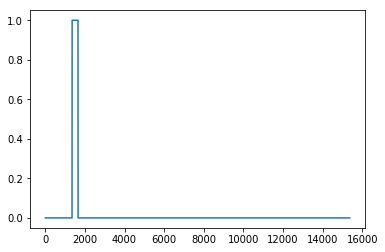

In [13]:
plt.plot(f_bar)

## Noise Delete

In [0]:
f = np.linspace(0,512,512*30)[ind_min:ind_max]

In [23]:
normal = [[np.zeros(f.shape[0]) for k in range(19)] for i in range(n_N)]
disorder = [[np.zeros(f.shape[0]) for k in range(19)] for i in range(n_D)]


FT = {'D':disorder,
     'N':normal}

from numpy.fft import fft

for d in range(n_D):
    for i in range(19):
        
        FT['D'][d][i] = np.abs(fft(data['D'][d][i]))[ind_min:ind_max]
        FT['D'][d][i][noise_index-del_domain  - ind_min: noise_index+del_domain - ind_min] = np.average(FT['D'][d][i][noise_index-del_domain  - ind_min - 120: noise_index+del_domain - ind_min-120])
        FT['D'][d][i][2*noise_index-del_domain - ind_min: 2*noise_index+del_domain - ind_min] = np.average(FT['D'][d][i][2*noise_index-del_domain - ind_min - 120: 2*noise_index+del_domain - ind_min-120])
    if (np.mod(d,100)==0):
       print('The progress is {}'.format(d/n_D * 50))
for n in range(n_N):
    for i in range(19):
        FT['N'][n][i] = np.abs(fft(data['N'][n][i]))[ind_min:ind_max]
        FT['N'][n][i][noise_index-del_domain - ind_min: noise_index+del_domain -ind_min] = np.average(FT['N'][n][i][noise_index-del_domain - ind_min-120: noise_index+del_domain -ind_min-120])
        FT['N'][n][i][2*noise_index-del_domain - ind_min: 2*noise_index+del_domain - ind_min] = np.average( FT['N'][n][i][2*noise_index-del_domain - ind_min-120 : 2*noise_index+del_domain - ind_min-120])
    if (np.mod(n,100)==0):
       print('The progress is {}'.format(n/n_N * 50 + 50))

    FT['N'] = np.array(FT['N'])
    FT['D'] = np.array(FT['D'])


The progress is 0.0
The progress is 3.5186488388458828
The progress is 7.0372976776917655
The progress is 10.555946516537649
The progress is 14.074595355383531
The progress is 17.593244194229417
The progress is 21.111893033075297
The progress is 24.63054187192118
The progress is 28.149190710767062
The progress is 31.667839549612946
The progress is 35.186488388458834
The progress is 38.70513722730472
The progress is 42.223786066150595
The progress is 45.74243490499648
The progress is 49.26108374384236
The progress is 50.0
The progress is 53.68459837877671
The progress is 57.369196757553425
The progress is 61.05379513633014
The progress is 64.73839351510685
The progress is 68.42299189388356
The progress is 72.10759027266027
The progress is 75.79218865143699
The progress is 79.4767870302137
The progress is 83.16138540899041
The progress is 86.84598378776712
The progress is 90.53058216654385
The progress is 94.21518054532055
The progress is 97.89977892409728


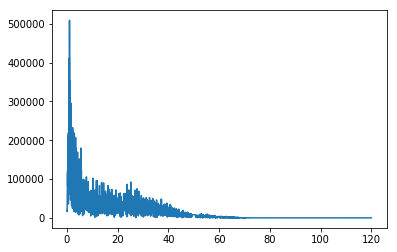

In [24]:
plt.plot(f, FT['D'][56][8])
#plt.plot(f, FT['D'][95][8])

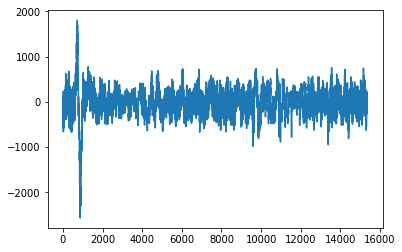

In [25]:
plt.plot(data['D'][3][4] - data['D'][50][4])

In [0]:
%reset_selective -f "^data$"

## Data Shaper and Scale

In [0]:
FT_matrix_N = FT['N']
FT_matrix_D = FT['D']

temp_D = FT_matrix_D.reshape((FT_matrix_D.shape[0],FT_matrix_D.shape[2],FT_matrix_D.shape[1]))
temp_N = FT_matrix_N.reshape((FT_matrix_N.shape[0],FT_matrix_N.shape[2],FT_matrix_N.shape[1]))
#or d in range(FT_matrix.shape[0]):
scaler = StandardScaler()

In [0]:
%reset_selective -f "^FT$"

In [0]:
for n in range(FT_matrix_N.shape[0]):
  temp_N[n]= scaler.fit_transform(FT_matrix_N[n].T)
  
for d in range(FT_matrix_D.shape[0]):
  temp_D[d]= scaler.fit_transform(FT_matrix_D[d].T)

In [0]:
for n in range(FT_matrix_N.shape[0]):
  FT_matrix_N[n]= scaler.fit_transform(temp_N[n].T)
  
for d in range(FT_matrix_D.shape[0]):
  FT_matrix_D[d]= scaler.fit_transform(temp_D[d].T)



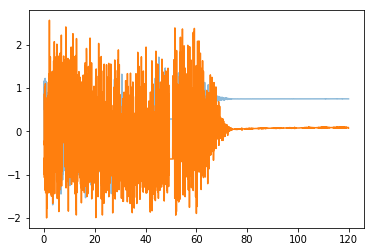

In [31]:
plt.plot(f,FT_matrix_D[16,5], alpha=0.5)
#plt.plot(f,FT_matrix_D[9,8])
plt.plot(f,FT_matrix_D[25,5])

In [0]:
# normal is 1 and disorder is 0
Data = np.vstack((FT_matrix_N, FT_matrix_D))
target = np.hstack((np.ones(FT_matrix_N.shape[0]), np.zeros(FT_matrix_D.shape[0])))

In [0]:
X, y = shuffle(Data, target)

In [34]:
X.shape, y.shape

((2778, 19, 3598), (2778,))

In [0]:
%reset_selective -f "^FT_matrix_D$"
%reset_selective -f "^FT_matrix_N$"
%reset_selective -f "^temp_D$"
%reset_selective -f "^temp_N$"
%reset_selective -f "^Data$"
%reset_selective -f "^target$"


#PCA

In [0]:
X = X.reshape(X.shape[0],-1)
X_train, X_test, y_train, y_test = train_test_split(X,y)

the scree plot of the features is :


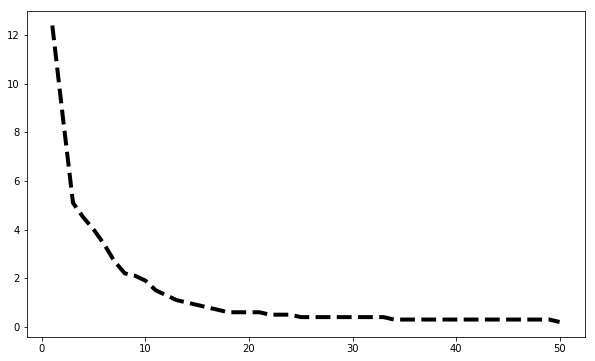

In [36]:


n=50
pca = PCA(n)
pca.fit(X_train)
data = pca.transform(X_train)
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
#labels = ["PC" + str(i) for i in range (1,len(per_var)+1)]
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(1,1,1)
print('the scree plot of the features is :')
#ax.bar(x=range(1,len(per_var)+1),height=per_var,tick_label=labels)
ax.plot(range(1,len(per_var)+1),per_var,'k--',linewidth=4,)



In [0]:
pca = PCA(n_components = 20)


In [0]:
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_train_pca.shape

In [0]:
X_test_pca = pca.transform(X_test)
X_test_pca.shape

#Decision Tree

In [37]:
model = DecisionTreeClassifier(max_depth=10)
model.fit(X_train_pca,y_train)

NameError: ignored

In [0]:
Y_predict = model.predict(X_test_pca)
cnfmatrix = confusion_matrix(y_test,Y_predict)
print(cnfmatrix)

In [0]:
clf_report = classification_report(y_test, Y_predict)
print(clf_report)

In [0]:
feature_names = ['PCA{}'.format(i) for i in range(1,X_train_pca.shape[1]+1)]
feature_names

In [0]:
target_names = ['disorder', 'normal']

In [0]:
export_graphviz(model,
               out_file='image.dot',
               feature_names=feature_names,
               class_names = target_names,
               rounded = True,
               filled=True)

In [0]:
! dot -Tpng image.dot -o image.png

In [0]:
from IPython.display import Image
Image('image.png')

# Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
rnd_clf = RandomForestClassifier(n_estimators=1900, max_depth=15, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1900,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [0]:
y_pred_rf = rnd_clf.predict(X_test)

In [0]:
feature_name = ['f={}'.format(i) for i in f]

In [42]:
cnfmatrix = confusion_matrix(y_test,y_pred_rf)
print(cnfmatrix)



[[357   8]
 [ 14 316]]


In [43]:
clf_report = classification_report(y_test, y_pred_rf)
print(clf_report)


              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       365
         1.0       0.98      0.96      0.97       330

    accuracy                           0.97       695
   macro avg       0.97      0.97      0.97       695
weighted avg       0.97      0.97      0.97       695



In [0]:
feat = rnd_clf.feature_importances_

In [0]:
feature = [(feat[i], feature_name[i]) for i in range(len(feature_name))]

In [46]:
len(feature_name)

3598

In [0]:
feature.sort()

In [50]:
for i in range(len(feature)):
  print(feature[-i])

(0.0, 'f=0.8667230939514291')
(0.0005000621181215918, 'f=49.66990038413959')
(0.00030797878832182946, 'f=69.83788007031707')
(0.0003060066837328643, 'f=49.736571391366624')
(0.0002923609421700731, 'f=67.17103978123575')
(0.0002906602785771134, 'f=50.40328146363695')
(0.0002881835115026798, 'f=50.30327495279641')
(0.00028668806207689663, 'f=49.76990689498014')
(0.0002806825549565479, 'f=72.738068884693')
(0.0002788992967031249, 'f=50.13659743472882')
(0.0002694417227023603, 'f=49.40321635523146')
(0.0002609823931799494, 'f=50.33661045640992')
(0.0002571972410134653, 'f=49.46988736245849')
(0.0002558422478491423, 'f=55.43694250927795')
(0.00025572687387378937, 'f=50.60329448531805')
(0.00025078889014115225, 'f=49.96991991666124')
(0.00024914267749521146, 'f=50.16993293834234')
(0.0002490426788410028, 'f=52.303405169607394')
(0.00024427569916244687, 'f=50.103261931115306')
(0.00024401120882932087, 'f=71.23797122208477')
(0.0002434652200854747, 'f=49.86991340582069')
(0.0002431684206178502